# 🤖 Training SegFormer cho Phân đoạn Khối u Da

Notebook này thực hiện training model **SegFormer** cho bài toán phân đoạn khối u da:

## 🎯 Model: SegFormer
- **Architecture**: Transformer-based segmentation
- **Backbone**: `nvidia/segformer-b0-finetuned-ade-512-512`
- **Parameters**: ~3.7M (rất nhẹ)
- **Ưu điểm**: Hiệu suất cao, ít tham số, xử lý tốt với medical images
- **Learning Rate Scheduler**: Cosine Annealing (phù hợp với transformer)

## 📊 Training Configuration:
- **Epochs**: 20
- **Learning Rate**: 5e-5 (thấp hơn cho pre-trained transformer)
- **Batch Size**: 8
- **Optimizer**: Adam với weight decay 1e-4
- **Loss Function**: Combined Loss (BCE + Dice)
- **Metrics**: Dice Coefficient, Jaccard Index (IoU)

## 1. Import thư viện và setup

### 🚨 Quan trọng: Cài đặt GPU Support

Để sử dụng GPU cho training, bạn cần:

1. **Kiểm tra GPU**: Chạy `nvidia-smi` trong terminal
2. **Cài CUDA Toolkit**: Tải từ [NVIDIA CUDA](https://developer.nvidia.com/cuda-downloads)
3. **Cài PyTorch với CUDA**: 
   ```bash
   pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
   ```
   (Thay `cu118` bằng phiên bản CUDA của bạn: cu117, cu118, cu121)

4. **Kiểm tra**: Chạy cell dưới để verify GPU hoạt động

In [19]:
# Cài đặt các thư viện cần thiết
# Cài đặt PyTorch với CUDA support (thay đổi cu118 theo phiên bản CUDA của bạn)
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers timm
!pip install albumentations opencv-python-headless
!pip install matplotlib seaborn scikit-learn pillow tqdm

In [20]:
# Kiểm tra CUDA và GPU
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Memory: {torch.cuda.get_device_properties(i).total_memory / 1024**3:.1f} GB")
else:
    print("❌ CUDA không khả dụng. Kiểm tra:")
    print("1. Driver GPU đã cài đặt chưa?")
    print("2. CUDA toolkit đã cài đặt chưa?")
    print("3. PyTorch có được cài với CUDA support không?")
    print("\n💡 Để cài PyTorch với CUDA:")
    print("pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118")

PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA version: 12.8
Number of GPUs: 1
GPU 0: NVIDIA GeForce RTX 5070 Ti
  Memory: 15.5 GB


In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Hugging Face Transformers
from transformers import (
    SegformerImageProcessor, SegformerForSemanticSegmentation,
    AutoImageProcessor, AutoModelForSemanticSegmentation
)

# Albumentations for augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Metrics
from sklearn.metrics import jaccard_score, f1_score

# Set device với thông tin chi tiết
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Using device: {device}")

if device.type == 'cuda':
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"📊 Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("⚠️  Đang sử dụng CPU - training sẽ chậm hơn")

# Tạo thư mục models nếu chưa có
os.makedirs('models', exist_ok=True)
print("✅ Setup hoàn tất!")

🔧 Using device: cuda
✅ GPU: NVIDIA GeForce RTX 5070 Ti
📊 Memory: 15.5 GB
✅ Setup hoàn tất!


## 2. Dataset và Data Augmentation

In [22]:
class ISICDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, target_size=(512, 512)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.target_size = target_size
        
        # Lấy danh sách file images
        self.image_files = sorted([f for f in os.listdir(images_dir) 
                                 if f.endswith(('.jpg', '.jpeg', '.png'))])
        
        print(f"Found {len(self.image_files)} images in {images_dir}")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Find corresponding mask
        base_name = os.path.splitext(img_name)[0]
        possible_mask_names = [
            f"{base_name}_segmentation.png",
            f"{base_name}_mask.png",
            f"{base_name}.png"
        ]
        
        mask = None
        for mask_name in possible_mask_names:
            mask_path = os.path.join(self.masks_dir, mask_name)
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                break
        
        if mask is None:
            # Create dummy mask if not found
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        
        # Resize
        image = cv2.resize(image, self.target_size)
        mask = cv2.resize(mask, self.target_size)
        
        # Convert mask to binary
        mask = (mask > 127).astype(np.float32)
        
        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # Convert to tensor if not already
        if not isinstance(image, torch.Tensor):
            image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
        
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask).float()
        
        # Ensure mask has correct shape [H, W] without channel dimension
        if mask.dim() == 3:
            mask = mask.squeeze()
        
        return image, mask

# Define augmentations
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

print("✅ Dataset class và augmentations đã được định nghĩa!")

✅ Dataset class và augmentations đã được định nghĩa!


In [23]:
# Create datasets
train_dataset = ISICDataset(
    images_dir='data/train/images',
    masks_dir='data/train/ground_truth',
    transform=train_transform,
    target_size=(512, 512)
)

val_dataset = ISICDataset(
    images_dir='data/val/images',
    masks_dir='data/val/ground_truth',
    transform=val_transform,
    target_size=(512, 512)
)

# Create data loaders
batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"📊 Dataset Summary:")
print(f"   - Training samples: {len(train_dataset)}")
print(f"   - Validation samples: {len(val_dataset)}")
print(f"   - Batch size: {batch_size}")
print(f"   - Training batches: {len(train_loader)}")
print(f"   - Validation batches: {len(val_loader)}")

Found 2594 images in data/train/images
Found 100 images in data/val/images
📊 Dataset Summary:
   - Training samples: 2594
   - Validation samples: 100
   - Batch size: 8
   - Training batches: 325
   - Validation batches: 13


## 3. SegFormer Model Definition

In [24]:
class SegFormerModel(nn.Module):
    def __init__(self, model_name="nvidia/segformer-b0-finetuned-ade-512-512", num_classes=1):
        super().__init__()
        
        # Load pre-trained SegFormer
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(
            model_name,
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )
        
        # Modify the classifier head for binary segmentation
        self.segformer.decode_head.classifier = nn.Conv2d(
            self.segformer.decode_head.classifier.in_channels,
            num_classes,
            kernel_size=1
        )
        
        print(f"✅ SegFormer model loaded: {model_name}")
        print(f"   - Number of classes: {num_classes}")
        
    def forward(self, x):
        # SegFormer forward pass
        outputs = self.segformer(pixel_values=x)
        logits = outputs.logits
        
        # Upsample to input resolution
        logits = F.interpolate(
            logits,
            size=x.shape[-2:],  # (H, W)
            mode='bilinear',
            align_corners=False
        )
        
        # Apply sigmoid for binary segmentation
        return torch.sigmoid(logits)

# Initialize model
print("🤖 Initializing SegFormer model...")
model = SegFormerModel(num_classes=1)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"📊 Model Statistics:")
print(f"   - Total parameters: {total_params:,}")
print(f"   - Trainable parameters: {trainable_params:,}")
print(f"   - Model size: ~{total_params/1e6:.1f}M parameters")

🤖 Initializing SegFormer model...


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([1, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ SegFormer model loaded: nvidia/segformer-b0-finetuned-ade-512-512
   - Number of classes: 1
📊 Model Statistics:
   - Total parameters: 3,714,401
   - Trainable parameters: 3,714,401
   - Model size: ~3.7M parameters


## 4. Loss Functions và Metrics

In [25]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        pred = pred.view(-1)
        target = target.view(-1)
        
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        
        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super().__init__()
        self.alpha = alpha
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()
        
    def forward(self, pred, target):
        # Ensure pred and target have the same shape
        # pred: [batch, 1, H, W], target: [batch, H, W]
        if pred.dim() == 4 and target.dim() == 3:
            pred = pred.squeeze(1)  # Remove channel dimension: [batch, H, W]
        elif pred.dim() == 3 and target.dim() == 4:
            target = target.squeeze(1)  # Remove channel dimension: [batch, H, W]
        
        return self.alpha * self.bce(pred, target) + (1 - self.alpha) * self.dice(pred, target)

def calculate_dice_batch(pred, target, threshold=0.5):
    """Calculate Dice coefficient for a batch"""
    # Ensure pred and target have the same shape
    if pred.dim() == 4 and target.dim() == 3:
        pred = pred.squeeze(1)  # Remove channel dimension
    elif pred.dim() == 3 and target.dim() == 4:
        target = target.squeeze(1)  # Remove channel dimension
    
    pred_binary = (pred > threshold).float()
    target_binary = target.float()
    
    intersection = (pred_binary * target_binary).sum()
    dice = (2. * intersection) / (pred_binary.sum() + target_binary.sum() + 1e-6)
    
    return dice.item()

def calculate_jaccard_batch(pred, target):
    """Calculate Jaccard Index (IoU) for a batch"""
    # Ensure pred and target have the same shape
    if pred.dim() == 4 and target.dim() == 3:
        pred = pred.squeeze(1)  # Remove channel dimension
    elif pred.dim() == 3 and target.dim() == 4:
        target = target.squeeze(1)  # Remove channel dimension
    
    # Convert to boolean for intersection and union
    pred_bool = pred.bool()
    target_bool = target.bool()
    
    intersection = (pred_bool & target_bool).float().sum()
    union = (pred_bool | target_bool).float().sum()
    
    jaccard = intersection / (union + 1e-6)
    return jaccard.item()

print("✅ Loss functions và metrics đã được định nghĩa!")

✅ Loss functions và metrics đã được định nghĩa!


## 5. Training Function

In [26]:
def train_segformer(model, train_loader, val_loader, num_epochs=20, lr=5e-5, patience=5, min_delta=0.001):
    """
    Training function for SegFormer with Cosine Annealing scheduler and Early Stopping
    
    Args:
        patience: Number of epochs to wait for improvement before stopping
        min_delta: Minimum change to qualify as an improvement
    """
    # Check device and move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    if device.type == 'cuda':
        print(f"🚀 Training on GPU: {torch.cuda.get_device_name(0)}")
        print(f"📊 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    else:
        print("⚠️  Training on CPU - sẽ chậm hơn rất nhiều!")
        print("💡 Để sử dụng GPU, cài PyTorch với CUDA support")
    
    # Loss function and optimizer
    criterion = CombinedLoss(alpha=0.5)  # Combination of BCE and Dice loss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    
    # Cosine Annealing scheduler (phù hợp với transformer)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=num_epochs, eta_min=lr*0.01
    )
    
    # Training history
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_dice': [],
        'val_dice': [],
        'train_jaccard': [],
        'val_jaccard': [],
        'learning_rates': []
    }
    
    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0
    early_stopped = False
    
    print(f"🚀 Bắt đầu training SegFormer...")
    print(f"📊 Configuration:")
    print(f"   - Epochs: {num_epochs}")
    print(f"   - Learning Rate: {lr}")
    print(f"   - Scheduler: Cosine Annealing")
    print(f"   - Loss: Combined (BCE + Dice)")
    print(f"   - Early Stopping: Patience={patience}, Min Delta={min_delta}")
    print("=" * 70)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        train_jaccard = 0.0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training')
        for batch_idx, (images, masks) in enumerate(train_pbar):
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            # Calculate metrics
            with torch.no_grad():
                pred_masks = outputs > 0.5
                dice = calculate_dice_batch(outputs, masks)
                jaccard = calculate_jaccard_batch(pred_masks, masks)
                train_dice += dice
                train_jaccard += jaccard
            
            train_loss += loss.item()
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}', 
                'Dice': f'{dice:.3f}', 
                'Jaccard': f'{jaccard:.3f}'
            })
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_jaccard = 0.0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation')
            for images, masks in val_pbar:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                # Calculate metrics
                pred_masks = outputs > 0.5
                dice = calculate_dice_batch(outputs, masks)
                jaccard = calculate_jaccard_batch(pred_masks, masks)
                val_dice += dice
                val_jaccard += jaccard
                
                val_loss += loss.item()
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}', 
                    'Dice': f'{dice:.3f}', 
                    'Jaccard': f'{jaccard:.3f}'
                })
        
        # Calculate averages
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_dice /= len(train_loader)
        val_dice /= len(val_loader)
        train_jaccard /= len(train_loader)
        val_jaccard /= len(val_loader)
        
        # Update learning rate
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step()
        new_lr = optimizer.param_groups[0]['lr']
        
        # Store history
        history['train_losses'].append(train_loss)
        history['val_losses'].append(val_loss)
        history['train_dice'].append(train_dice)
        history['val_dice'].append(val_dice)
        history['train_jaccard'].append(train_jaccard)
        history['val_jaccard'].append(val_jaccard)
        history['learning_rates'].append(current_lr)
        
        # Print epoch summary
        if abs(current_lr - new_lr) > 1e-8:
            print(f"  Learning rate changed: {current_lr:.6f} -> {new_lr:.6f}")
        
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, Train Jaccard: {train_jaccard:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}, Val Jaccard: {val_jaccard:.4f}")
        print(f"  LR: {current_lr:.6f}")
        print("-" * 70)
        
        # Save best model and early stopping logic
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'models/segformer_model_best.pth')
            print(f"✅ New best validation loss: {val_loss:.4f} (patience reset)")
        else:
            patience_counter += 1
            print(f"⏳ No improvement. Patience: {patience_counter}/{patience}")
            
            if patience_counter >= patience:
                print(f"\n🛑 Early stopping triggered after {epoch+1} epochs!")
                print(f"   Best validation loss: {best_val_loss:.4f}")
                early_stopped = True
                break
    
    # Training completion message
    if early_stopped:
        print(f"\n🏁 Training stopped early at epoch {epoch+1}/{num_epochs}")
    else:
        print(f"\n🏁 Training completed all {num_epochs} epochs")
    
    print(f"📊 Final best validation loss: {best_val_loss:.4f}")
    
    return history

print("✅ Training function đã được định nghĩa!")

✅ Training function đã được định nghĩa!


## 6. Bắt đầu Training

In [27]:
# Train the SegFormer model
print("🚀 Bắt đầu training SegFormer...")
print("⏰ Thời gian dự kiến: ~1-2 giờ (với early stopping)")
print()

segformer_history = train_segformer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=20,
    lr=5e-5,
    patience=5,      # Dừng sớm sau 5 epochs không cải thiện
    min_delta=0.001  # Cải thiện tối thiểu 0.001 để được tính
)

# Save final model
torch.save(model.state_dict(), 'models/segformer_model_final.pth')
print("\n🎉 SegFormer training hoàn thành!")
print("💾 Model đã được lưu:")
print("   - models/segformer_model_best.pth (best validation loss)")
print("   - models/segformer_model_final.pth (final epoch)")

🚀 Bắt đầu training SegFormer...
⏰ Thời gian dự kiến: ~1-2 giờ (với early stopping)

🚀 Training on GPU: NVIDIA GeForce RTX 5070 Ti
📊 GPU Memory: 15.5 GB
🚀 Bắt đầu training SegFormer...
📊 Configuration:
   - Epochs: 20
   - Learning Rate: 5e-05
   - Scheduler: Cosine Annealing
   - Loss: Combined (BCE + Dice)
   - Early Stopping: Patience=5, Min Delta=0.001


Epoch 1/20 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.20it/s, Loss=0.1499, Dice=0.905, Jaccard=0.827]


  Learning rate changed: 0.000050 -> 0.000050
Epoch 1/20:
  Train Loss: 0.2954, Train Dice: 0.8261, Train Jaccard: 0.7193
  Val Loss: 0.1784, Val Dice: 0.8840, Val Jaccard: 0.7946
  LR: 0.000050
----------------------------------------------------------------------
✅ New best validation loss: 0.1784 (patience reset)


Epoch 2/20 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.31it/s, Loss=0.1100, Dice=0.921, Jaccard=0.853]


  Learning rate changed: 0.000050 -> 0.000049
Epoch 2/20:
  Train Loss: 0.1739, Train Dice: 0.8830, Train Jaccard: 0.7953
  Val Loss: 0.1461, Val Dice: 0.8936, Val Jaccard: 0.8127
  LR: 0.000050
----------------------------------------------------------------------
✅ New best validation loss: 0.1461 (patience reset)


Epoch 3/20 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.04it/s, Loss=0.1455, Dice=0.880, Jaccard=0.786]


  Learning rate changed: 0.000049 -> 0.000047
Epoch 3/20:
  Train Loss: 0.1394, Train Dice: 0.8979, Train Jaccard: 0.8182
  Val Loss: 0.1328, Val Dice: 0.9011, Val Jaccard: 0.8216
  LR: 0.000049
----------------------------------------------------------------------
✅ New best validation loss: 0.1328 (patience reset)


Epoch 4/20 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.28it/s, Loss=0.1915, Dice=0.845, Jaccard=0.732]


  Learning rate changed: 0.000047 -> 0.000045
Epoch 4/20:
  Train Loss: 0.1376, Train Dice: 0.8902, Train Jaccard: 0.8087
  Val Loss: 0.1819, Val Dice: 0.8677, Val Jaccard: 0.7705
  LR: 0.000047
----------------------------------------------------------------------
⏳ No improvement. Patience: 1/5


Epoch 5/20 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.19it/s, Loss=0.1338, Dice=0.890, Jaccard=0.802]


  Learning rate changed: 0.000045 -> 0.000043
Epoch 5/20:
  Train Loss: 0.1223, Train Dice: 0.9016, Train Jaccard: 0.8241
  Val Loss: 0.1235, Val Dice: 0.9055, Val Jaccard: 0.8296
  LR: 0.000045
----------------------------------------------------------------------
✅ New best validation loss: 0.1235 (patience reset)


Epoch 6/20 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.07it/s, Loss=0.1611, Dice=0.863, Jaccard=0.760]


  Learning rate changed: 0.000043 -> 0.000040
Epoch 6/20:
  Train Loss: 0.1139, Train Dice: 0.9071, Train Jaccard: 0.8333
  Val Loss: 0.1449, Val Dice: 0.8875, Val Jaccard: 0.8008
  LR: 0.000043
----------------------------------------------------------------------
⏳ No improvement. Patience: 1/5


Epoch 7/20 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.29it/s, Loss=0.1158, Dice=0.896, Jaccard=0.811]


  Learning rate changed: 0.000040 -> 0.000036
Epoch 7/20:
  Train Loss: 0.1079, Train Dice: 0.9117, Train Jaccard: 0.8403
  Val Loss: 0.1156, Val Dice: 0.9102, Val Jaccard: 0.8371
  LR: 0.000040
----------------------------------------------------------------------
✅ New best validation loss: 0.1156 (patience reset)


Epoch 8/20 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.34it/s, Loss=0.1477, Dice=0.870, Jaccard=0.769]


  Learning rate changed: 0.000036 -> 0.000033
Epoch 8/20:
  Train Loss: 0.1051, Train Dice: 0.9127, Train Jaccard: 0.8419
  Val Loss: 0.1187, Val Dice: 0.9084, Val Jaccard: 0.8342
  LR: 0.000036
----------------------------------------------------------------------
⏳ No improvement. Patience: 1/5


Epoch 9/20 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.10it/s, Loss=0.1013, Dice=0.910, Jaccard=0.834]


  Learning rate changed: 0.000033 -> 0.000029
Epoch 9/20:
  Train Loss: 0.1023, Train Dice: 0.9156, Train Jaccard: 0.8464
  Val Loss: 0.1275, Val Dice: 0.8997, Val Jaccard: 0.8222
  LR: 0.000033
----------------------------------------------------------------------
⏳ No improvement. Patience: 2/5


Epoch 10/20 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.27it/s, Loss=0.1523, Dice=0.873, Jaccard=0.775]


  Learning rate changed: 0.000029 -> 0.000025
Epoch 10/20:
  Train Loss: 0.1015, Train Dice: 0.9152, Train Jaccard: 0.8463
  Val Loss: 0.1266, Val Dice: 0.9061, Val Jaccard: 0.8304
  LR: 0.000029
----------------------------------------------------------------------
⏳ No improvement. Patience: 3/5


Epoch 11/20 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.25it/s, Loss=0.1219, Dice=0.888, Jaccard=0.798]


  Learning rate changed: 0.000025 -> 0.000021
Epoch 11/20:
  Train Loss: 0.0976, Train Dice: 0.9177, Train Jaccard: 0.8500
  Val Loss: 0.1176, Val Dice: 0.9075, Val Jaccard: 0.8330
  LR: 0.000025
----------------------------------------------------------------------
⏳ No improvement. Patience: 4/5


Epoch 12/20 - Validation: 100%|██████████| 13/13 [00:02<00:00,  5.26it/s, Loss=0.1265, Dice=0.890, Jaccard=0.801]

  Learning rate changed: 0.000021 -> 0.000018
Epoch 12/20:
  Train Loss: 0.0962, Train Dice: 0.9187, Train Jaccard: 0.8520
  Val Loss: 0.1195, Val Dice: 0.9098, Val Jaccard: 0.8367
  LR: 0.000021
----------------------------------------------------------------------
⏳ No improvement. Patience: 5/5

🛑 Early stopping triggered after 12 epochs!
   Best validation loss: 0.1156

🏁 Training stopped early at epoch 12/20
📊 Final best validation loss: 0.1156

🎉 SegFormer training hoàn thành!
💾 Model đã được lưu:
   - models/segformer_model_best.pth (best validation loss)
   - models/segformer_model_final.pth (final epoch)


## 7. Visualization và Evaluation

📊 Hiển thị training history:


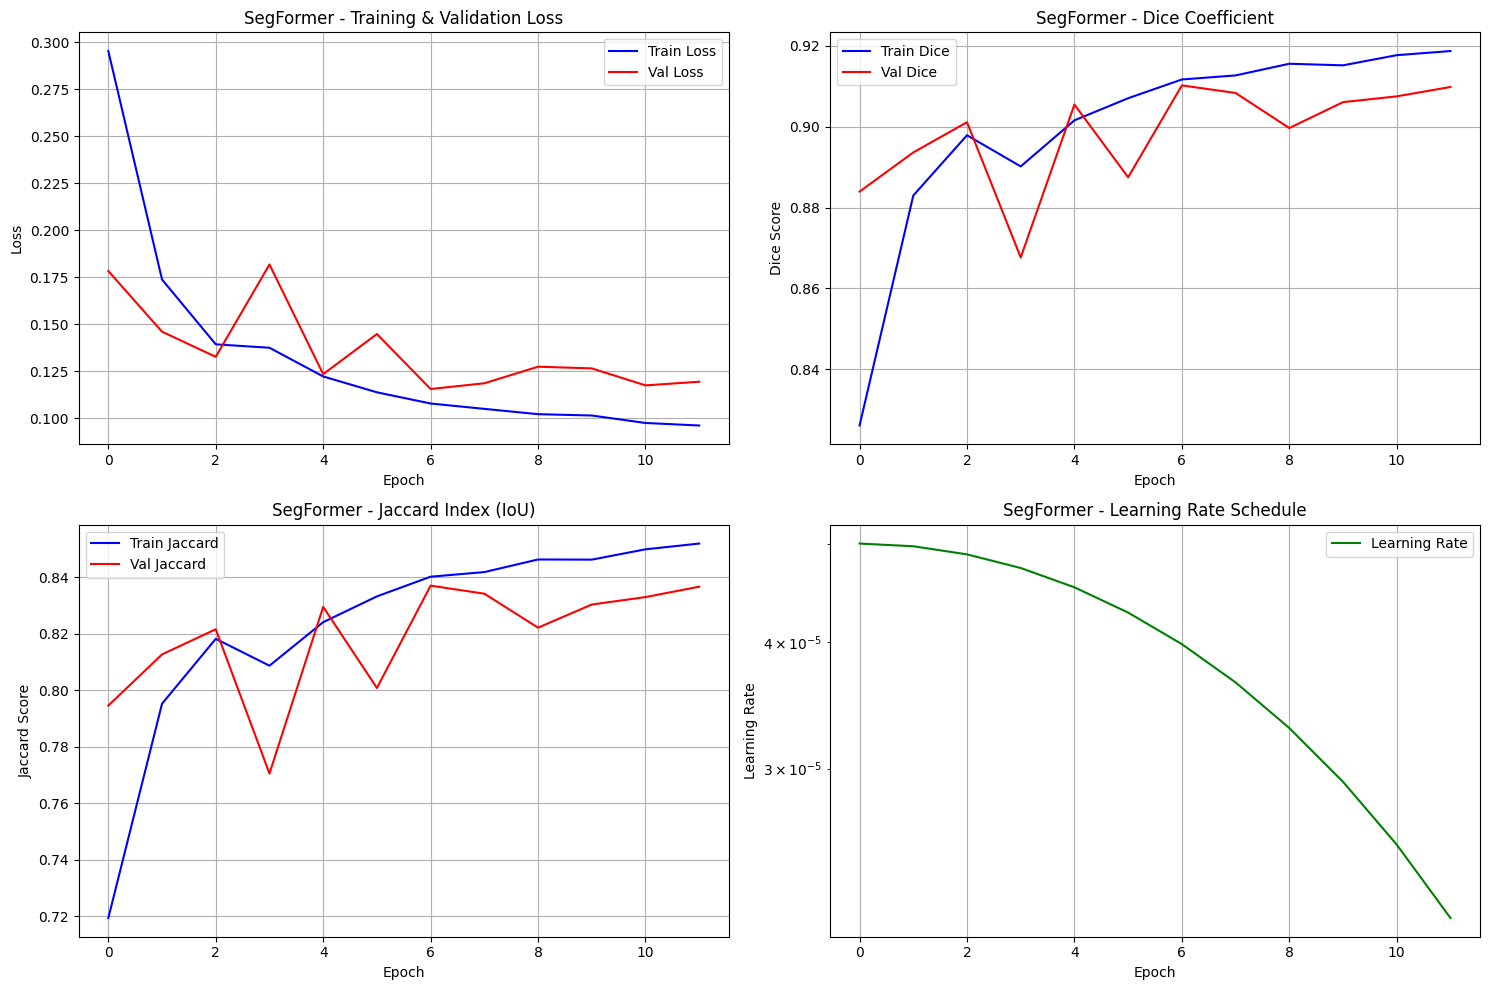

In [32]:
def plot_training_history(history, model_name="SegFormer"):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history['train_losses'], label='Train Loss', color='blue')
    axes[0, 0].plot(history['val_losses'], label='Val Loss', color='red')
    axes[0, 0].set_title(f'{model_name} - Training & Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Dice Coefficient
    axes[0, 1].plot(history['train_dice'], label='Train Dice', color='blue')
    axes[0, 1].plot(history['val_dice'], label='Val Dice', color='red')
    axes[0, 1].set_title(f'{model_name} - Dice Coefficient')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Dice Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Jaccard Index
    axes[1, 0].plot(history['train_jaccard'], label='Train Jaccard', color='blue')
    axes[1, 0].plot(history['val_jaccard'], label='Val Jaccard', color='red')
    axes[1, 0].set_title(f'{model_name} - Jaccard Index (IoU)')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Jaccard Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Learning Rate
    axes[1, 1].plot(history['learning_rates'], label='Learning Rate', color='green')
    axes[1, 1].set_title(f'{model_name} - Learning Rate Schedule')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    axes[1, 1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()

# Plot training history
print("📊 Hiển thị training history:")
plot_training_history(segformer_history, "SegFormer")

🔍 Đánh giá model trên validation samples:


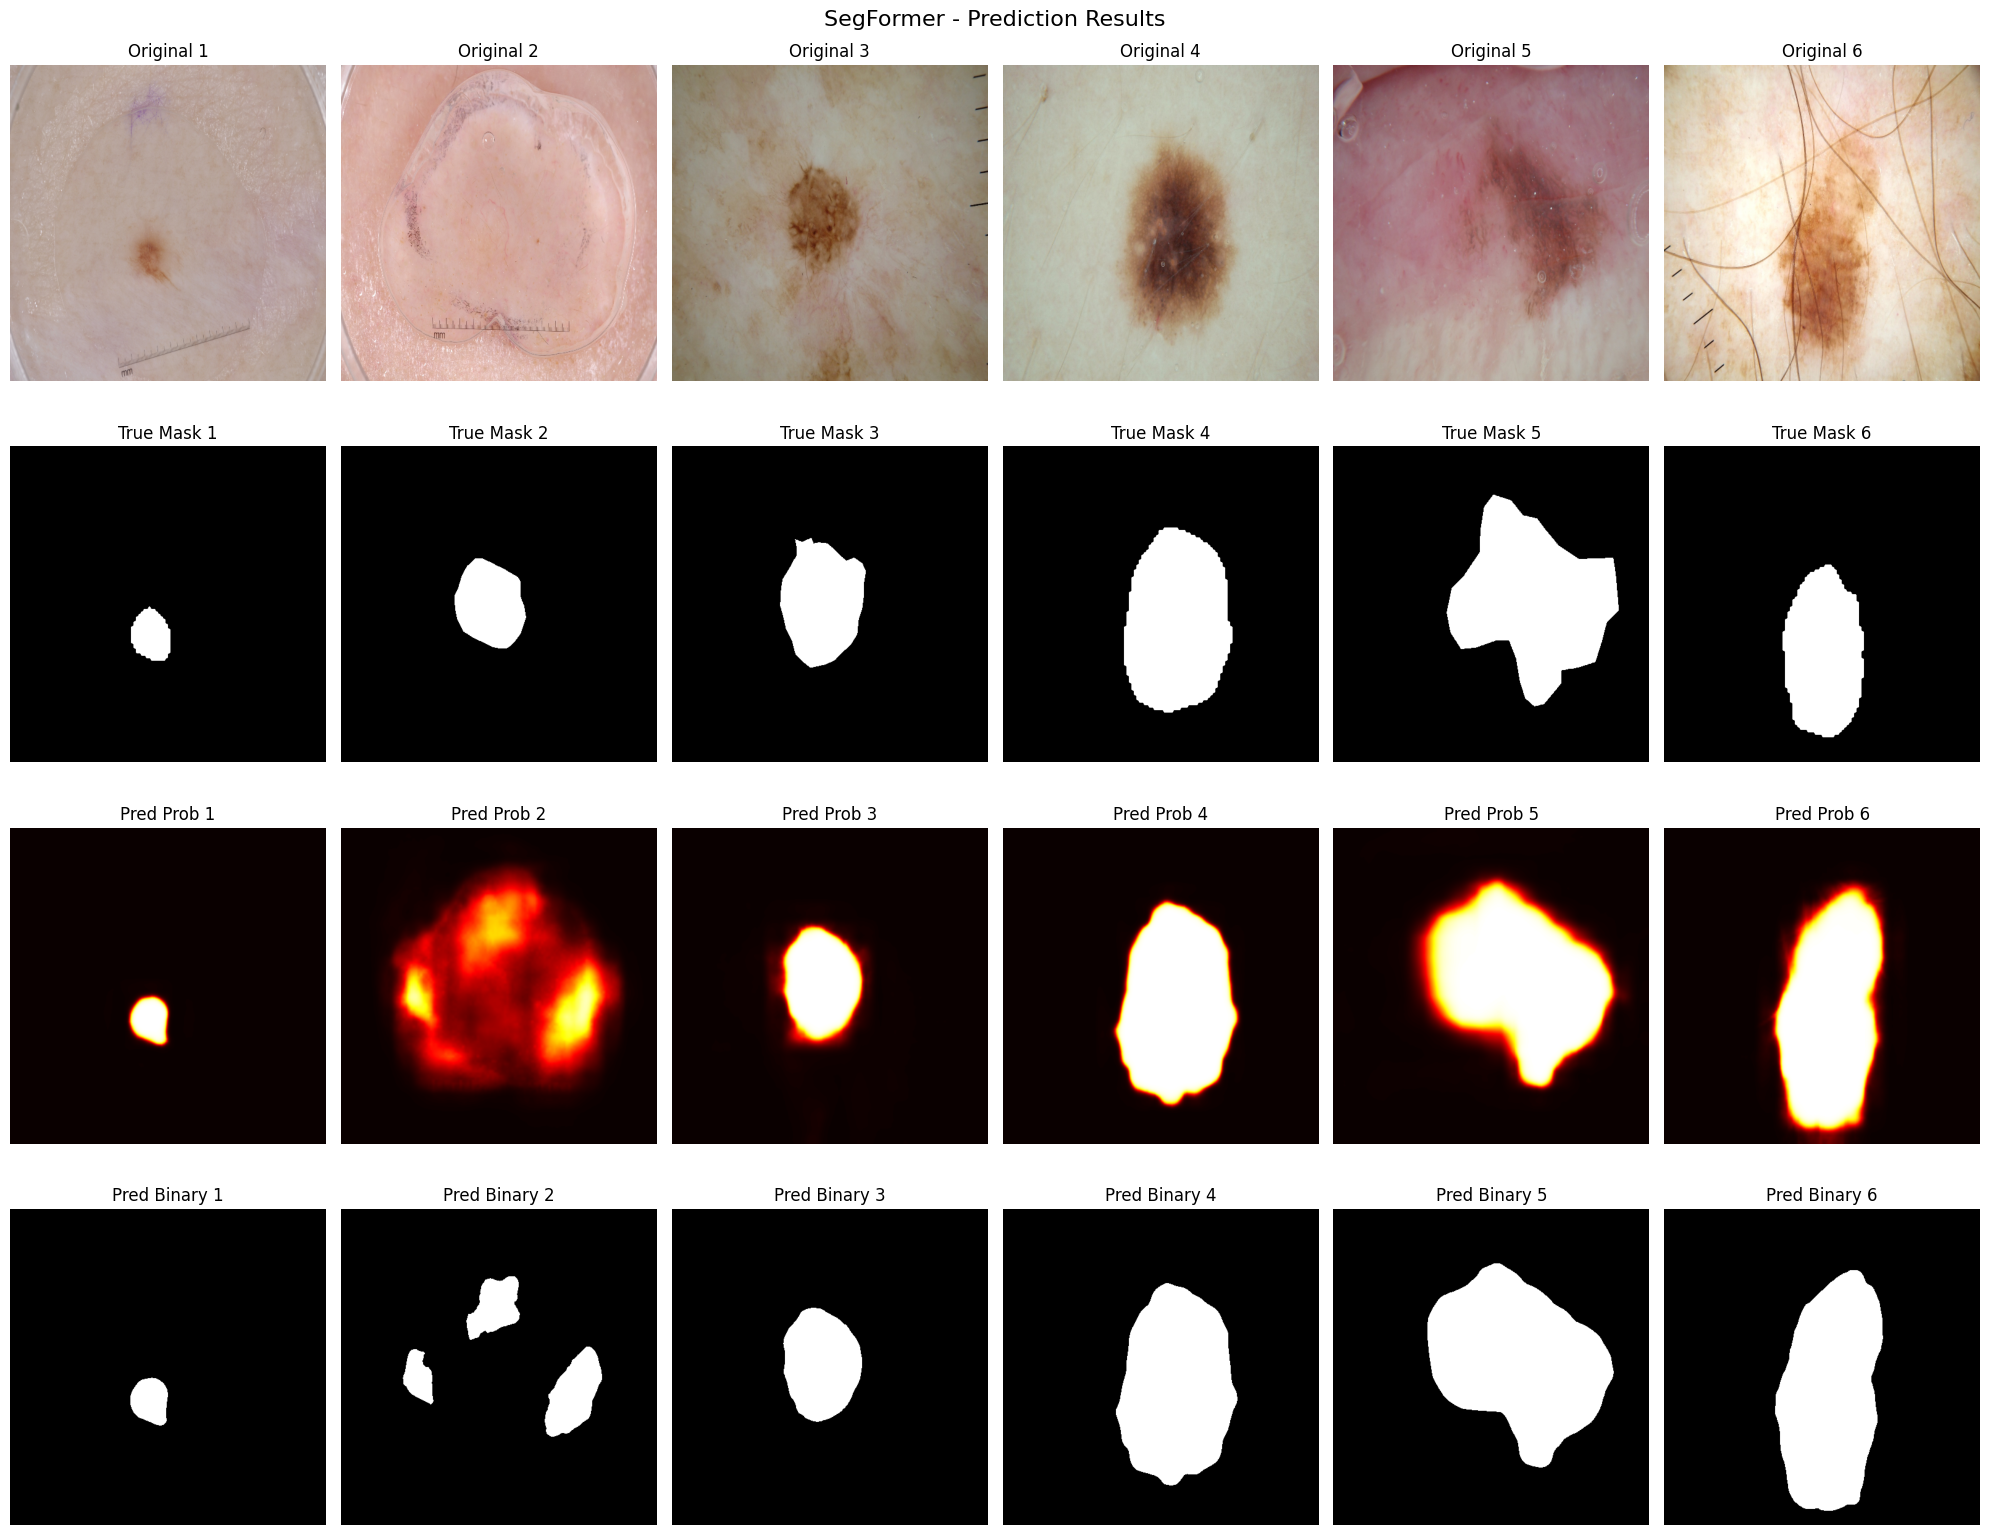

In [33]:
def evaluate_model_on_samples(model, val_loader, num_samples=6):
    """Evaluate model on sample images"""
    model.eval()
    
    # Get some samples
    samples = []
    with torch.no_grad():
        for i, (images, masks) in enumerate(val_loader):
            if i >= num_samples // val_loader.batch_size + 1:
                break
                
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            
            for j in range(min(images.shape[0], num_samples - len(samples))):
                # Denormalize image for visualization
                img = images[j].cpu()
                mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                img = img * std + mean
                img = torch.clamp(img, 0, 1)
                
                # Handle different tensor shapes
                if masks.dim() == 3:  # [batch, H, W]
                    true_mask = masks[j].cpu().numpy()
                else:  # [batch, 1, H, W]
                    true_mask = masks[j, 0].cpu().numpy()
                
                if outputs.dim() == 3:  # [batch, H, W]
                    pred_mask = outputs[j].cpu().numpy()
                    pred_binary = (outputs[j] > 0.5).cpu().numpy().astype(np.uint8)
                else:  # [batch, 1, H, W]
                    pred_mask = outputs[j, 0].cpu().numpy()
                    pred_binary = (outputs[j, 0] > 0.5).cpu().numpy().astype(np.uint8)
                
                samples.append({
                    'image': img.permute(1, 2, 0).numpy(),
                    'true_mask': true_mask,
                    'pred_mask': pred_mask,
                    'pred_binary': pred_binary
                })
                
                if len(samples) >= num_samples:
                    break
    
    # Visualize results
    fig, axes = plt.subplots(4, len(samples), figsize=(20, 16))
    
    for i, sample in enumerate(samples):
        # Original image
        axes[0, i].imshow(sample['image'])
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].axis('off')
        
        # True mask
        axes[1, i].imshow(sample['true_mask'], cmap='gray')
        axes[1, i].set_title(f'True Mask {i+1}')
        axes[1, i].axis('off')
        
        # Predicted mask (probability)
        axes[2, i].imshow(sample['pred_mask'], cmap='hot', vmin=0, vmax=1)
        axes[2, i].set_title(f'Pred Prob {i+1}')
        axes[2, i].axis('off')
        
        # Predicted mask (binary)
        axes[3, i].imshow(sample['pred_binary'], cmap='gray')
        axes[3, i].set_title(f'Pred Binary {i+1}')
        axes[3, i].axis('off')
    
    plt.suptitle('SegFormer - Prediction Results', fontsize=16)
    plt.tight_layout()
    plt.show()

# Evaluate model on samples
print("🔍 Đánh giá model trên validation samples:")
evaluate_model_on_samples(model, val_loader, num_samples=6)

## 8. Final Results Summary

In [34]:
# Print final results
print("🎯 SEGFORMER TRAINING RESULTS")
print("=" * 50)
print(f"📊 Final Metrics (Last Epoch):")
print(f"   - Training Loss: {segformer_history['train_losses'][-1]:.4f}")
print(f"   - Validation Loss: {segformer_history['val_losses'][-1]:.4f}")
print(f"   - Training Dice: {segformer_history['train_dice'][-1]:.4f}")
print(f"   - Validation Dice: {segformer_history['val_dice'][-1]:.4f}")
print(f"   - Training Jaccard: {segformer_history['train_jaccard'][-1]:.4f}")
print(f"   - Validation Jaccard: {segformer_history['val_jaccard'][-1]:.4f}")

print(f"\n🏆 Best Metrics:")
best_val_dice_idx = np.argmax(segformer_history['val_dice'])
best_val_jaccard_idx = np.argmax(segformer_history['val_jaccard'])
print(f"   - Best Validation Dice: {max(segformer_history['val_dice']):.4f} (Epoch {best_val_dice_idx + 1})")
print(f"   - Best Validation Jaccard: {max(segformer_history['val_jaccard']):.4f} (Epoch {best_val_jaccard_idx + 1})")

print(f"\n💾 Saved Models:")
print(f"   - models/segformer_model_best.pth")
print(f"   - models/segformer_model_final.pth")

print(f"\n📈 Model Performance:")
final_dice = segformer_history['val_dice'][-1]
final_jaccard = segformer_history['val_jaccard'][-1]

if final_dice > 0.85:
    print(f"   ✅ Excellent performance! Dice > 0.85")
elif final_dice > 0.80:
    print(f"   ✅ Good performance! Dice > 0.80")
elif final_dice > 0.75:
    print(f"   ⚠️  Acceptable performance. Dice > 0.75")
else:
    print(f"   ❌ Performance needs improvement. Dice < 0.75")

print(f"\n🚀 Next Steps:")
print(f"   1. Evaluate on test set")
print(f"   2. Run 03_train_unet_efficientnet.ipynb to train U-Net EfficientNet")
print(f"   3. Run 04_train_unet_vit.ipynb to train U-Net ViT")
print(f"   4. Run 05_train_deeplabv3_resnet.ipynb to train DeepLabV3+ ResNet")
print(f"   5. Compare all models' performance")

print("\n✅ SegFormer training completed successfully!")

🎯 SEGFORMER TRAINING RESULTS
📊 Final Metrics (Last Epoch):
   - Training Loss: 0.0962
   - Validation Loss: 0.1195
   - Training Dice: 0.9187
   - Validation Dice: 0.9098
   - Training Jaccard: 0.8520
   - Validation Jaccard: 0.8367

🏆 Best Metrics:
   - Best Validation Dice: 0.9102 (Epoch 7)
   - Best Validation Jaccard: 0.8371 (Epoch 7)

💾 Saved Models:
   - models/segformer_model_best.pth
   - models/segformer_model_final.pth

📈 Model Performance:
   ✅ Excellent performance! Dice > 0.85

🚀 Next Steps:
   1. Evaluate on test set
   2. Run 03_train_unet_efficientnet.ipynb to train U-Net EfficientNet
   3. Run 04_train_unet_vit.ipynb to train U-Net ViT
   4. Run 05_train_deeplabv3_resnet.ipynb to train DeepLabV3+ ResNet
   5. Compare all models' performance

✅ SegFormer training completed successfully!
